In [3]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
import warnings

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from scipy.stats import energy_distance

matplotlib.rcdefaults()

from pathlib import Path
matplotlib_rc = { 
    # 'text': {'usetex': True}, 
    'font': {'family': 'serif'} } # Apply changes for k, v in matplotlib_rc.items(): rc(k, **v)
for k, v in matplotlib_rc.items():
          rc(k, **v)

In [4]:
def update_dict(d, upt):
    for k in upt:
        if k not in d:
            d[k] = []
        d[k].append(upt[k])
    return d

In [5]:
warnings.filterwarnings('ignore')

In [6]:
def remove_outliers(df, column, lower_percentile=0.05, upper_percentile=0.95):
    """
    Remove outliers from a DataFrame based on percentile method for a specific column for each dataset.
    
    Parameters:
    - df: DataFrame from which to remove outliers.
    - column: Column name to check for outliers.
    - lower_percentile: Lower percentile threshold for outlier removal.
    - upper_percentile: Upper percentile threshold for outlier removal.
    
    Returns:
    - DataFrame with outliers removed.
    """
    def remove_outliers_group(group):
        lower_bound = group[column].quantile(lower_percentile)
        upper_bound = group[column].quantile(upper_percentile)
        new_group = group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
        print(f"Removed {group.shape[0] - new_group.shape[0]} obs from {group['Dataset'].iloc[0]}")
        return new_group

    return df.groupby('Dataset').apply(remove_outliers_group).reset_index(drop=True)


def plot_log_mean_vs_log_variance(real_adata, generated_adatas_dict, dataset, folder, xlim=(0,100), ylim=(0,100), quantile=(0.0,0.999)):
    """
    Plots the log mean vs log variance for real and generated AnnData objects using seaborn.

    Parameters:
    - real_adata: AnnData object for the real dataset.
    - generated_adatas_dict: Dictionary with model names as keys and AnnData objects as values.
    """
    save_path = Path(folder)
    # Calculate and plot for the real dataset
    # X_real = (np.exp(real_adata.X.A - 1)X_real = (np.exp(real_adata.X.A - 1)))
    X_real = real_adata.X.A
    real_means = np.mean(X_real, axis=0)
    real_vars = np.var(X_real, axis=0)
    # real_means = np.log(np.mean(X_real, axis=0))
    # real_vars = np.log(np.var(X_real, axis=0))
    
    # Create a DataFrame for seaborn
    real_ratio = (real_vars/real_means)
    real_ratio = real_ratio[~np.isnan(real_ratio)]
    data = {
        'Mean': list(real_means),
        'Variance': list(real_vars),
        #'Variance/Mean': list(real_means/real_vars),
        'Dataset': ['Real data' for _ in range(len(real_means))]
    }

    wass = {}
    for model_name, adata in generated_adatas_dict.items():
        if sp.issparse(adata.X):
            X = adata.X.A
        else:
            X = adata.X
        means = np.mean(X, axis=0)
        vars = np.var(X, axis=0)
        # means = np.log(np.mean(X, axis=0))
        # vars = np.log(np.var(X, axis=0))


        # Append to the data dictionary
        data['Mean'] += list(means)
        data['Variance'] += list(vars)
        gen_ratio = (vars/means)
        gen_ratio = gen_ratio[~np.isnan(gen_ratio)]
        #data['Variance/Mean'] += list(gen_ratio)
        print(f"Wasserstein distance true/generated {model_name}: {wasserstein_distance(gen_ratio, real_ratio)}")
        print(f"Energy distance true/generated {model_name}: {energy_distance(gen_ratio, real_ratio)}")
        wass[model_name] = wasserstein_distance(gen_ratio, real_ratio)
        data['Dataset'] += [model_name for _ in range(len(means))]
    
    # Convert the data dictionary to a DataFrame
    import pandas as pd
    df = pd.DataFrame(data)
    df = remove_outliers(df, 'Mean', lower_percentile=quantile[0], upper_percentile=quantile[1])

    # plt.figure(figsize=(5,7))
    # Plot with seaborn
    pl = sns.lmplot(data=df, x='Mean', y='Variance', hue='Dataset', palette='colorblind', order=2, 
                   scatter=True, height=3, legend=False, line_kws= {"linewidth": 2}, scatter_kws={"s": 20, "alpha": 0.05})
    # pl = sns.scatterplot(data=df, x='Mean', y='Variance', hue='Dataset', palette='colorblind', s=8, alpha=0.5, legend=False)

    print()

    if ylim:
        plt.ylim(ylim[0], ylim[1])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
        
    plt.xlabel('Gene mean (log-GEXP)')
    plt.ylabel('Gene variance (log-GEXP)')
    plt.title(dataset)
    plt.xticks(rotation=45)  
    # plt.legend()
    plt.tight_layout()
    plt.savefig(save_path / (dataset+".png"), format='png', dpi=800)
    plt.show()

    return wass


In [7]:
folder ="/home/icb/alessandro.palma/environment/cfgen/figs/overdispersion"

## Dentategyrus

Run 0
Wasserstein distance true/generated CFGgen: 0.047886371175348524
Energy distance true/generated CFGgen: 0.07270398626024886
Wasserstein distance true/generated scDiffusion: 0.7257511028891086
Energy distance true/generated scDiffusion: 1.0061981992744633
Wasserstein distance true/generated scGAN: 0.032818819697027914
Energy distance true/generated scGAN: 0.06891085704929946
Wasserstein distance true/generated scVI: 0.03279714702485401
Energy distance true/generated scVI: 0.0611988620828854
Removed 171 obs from CFGgen
Removed 171 obs from Real data
Removed 171 obs from scDiffusion
Removed 171 obs from scGAN
Removed 171 obs from scVI



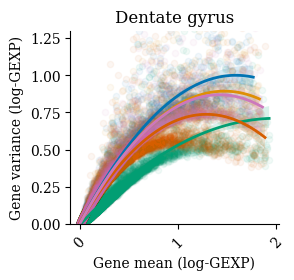

Run 1
Wasserstein distance true/generated CFGgen: 0.045449822916590416
Energy distance true/generated CFGgen: 0.06854269909448117
Wasserstein distance true/generated scDiffusion: 0.7394579492894512
Energy distance true/generated scDiffusion: 1.0135619946267869
Wasserstein distance true/generated scGAN: 0.03282271640138012
Energy distance true/generated scGAN: 0.06786780379262065
Wasserstein distance true/generated scVI: 0.0322994012949135
Energy distance true/generated scVI: 0.0609793818674454
Removed 171 obs from CFGgen
Removed 171 obs from Real data
Removed 171 obs from scDiffusion
Removed 171 obs from scGAN
Removed 171 obs from scVI



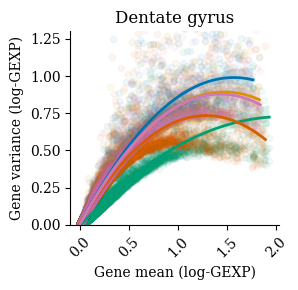

Run 2
Wasserstein distance true/generated CFGgen: 0.03882680012920085
Energy distance true/generated CFGgen: 0.056423271551181355
Wasserstein distance true/generated scDiffusion: 0.7499863788934655
Energy distance true/generated scDiffusion: 1.0192599494143721
Wasserstein distance true/generated scGAN: 2.733840252009399
Energy distance true/generated scGAN: 2.0162253402037806
Wasserstein distance true/generated scVI: 0.03372854609001889
Energy distance true/generated scVI: 0.062360563988266664
Removed 171 obs from CFGgen
Removed 171 obs from Real data
Removed 171 obs from scDiffusion
Removed 171 obs from scGAN
Removed 171 obs from scVI



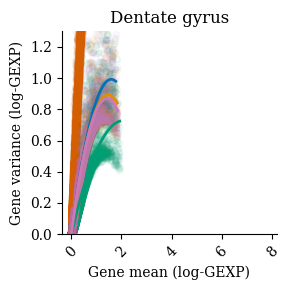

In [8]:
adata_real_dent = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/dentategyrus/dentategyrus_test.h5ad")
wasserstein_dent = {}

for i in range(3):
    print(f"Run {i}")
    adata_celldreamer_dent = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/dentategyrus/generated_cells_{i}.h5ad")
    adata_scDiff_dent = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scDiffusion/generated/dentategyrus/generated_cells_{i}.h5ad")
    adata_scgan_dent = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scgan/model_runs/dentategyrus/dentategyrus_generated_{i}.h5ad")
    adata_scvi_dent = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scvi/dentategyrus/generated/dentategyrus_{i}.h5ad")
    wass = plot_log_mean_vs_log_variance(adata_real_dent, 
                              {"CFGgen": adata_celldreamer_dent, 
                               "scDiffusion": adata_scDiff_dent,
                              "scGAN": adata_scgan_dent,
                              "scVI": adata_scvi_dent}, 
                              "Dentate gyrus", 
                              folder=folder,
                              xlim=None, ylim=(0,1.3), quantile=(0,0.99))
    wasserstein_dent = update_dict(wasserstein_dent, wass)

In [9]:
for w in wasserstein_dent:
    print(w)
    print(np.mean(wasserstein_dent[w]))
    print(np.std(wasserstein_dent[w])/np.sqrt(3))

CFGgen
0.0440543314070466
0.0022100530058980724
scDiffusion
0.7383984770240085
0.0057286611168515635
scGAN
0.9331605960359357
0.7351243912247971
scVI
0.03294169813659547
0.0003419827738590469


## Tabula Muris

In [13]:
def plot_sparsity_histograms(adata_generated, adata_real, folder, dataset_name, xlim=None, bins=30):
    """
    Plots histograms of gene expression sparsity for real and generated datasets.
    
    Parameters:
    adata_generated (dict): Dictionary where keys are model names and values are generated anndata objects.
    adata_real (anndata.AnnData): AnnData object of the real dataset.
    """
    save_path = Path(folder)
    # Compute sparsity for the real dataset
    sparsity_real = (adata_real.X.A == 0).sum(1)
    print(sparsity_real.shape)
    sparsity_real_df = {'Number of zeroes per cell': list(sparsity_real),
                                     'Model': ['Real data' for _ in range(len(sparsity_real))]}
    
    # Compute sparsity for each generated dataset
    wass = {}
    for model_name, adata in adata_generated.items():
        if sp.issparse(adata.X):
            sparsity_generated = (adata.X.A == 0).sum(1)
        else:
            sparsity_generated = (adata.X == 0).sum(1)
        print(sparsity_generated.shape)
        sparsity_real_df['Number of zeroes per cell'] += list(sparsity_generated)
        sparsity_real_df['Model'] += [model_name for _ in range(len(sparsity_generated))]
        print(f"Wasserstein distance true/generated {model_name}: {wasserstein_distance(sparsity_generated, sparsity_real)}")
        print(f"Energy distance true/generated {model_name}: {energy_distance(sparsity_generated, sparsity_real)}")
        wass[model_name] = wasserstein_distance(sparsity_generated, sparsity_real)
    
    # Plotting
    plt.figure(figsize=(3, 3))
    # hist = sns.histplot(data=sparsity_real_df, x='Number of zeroes per cell', hue='Model', kde=True, alpha=0.2, 
    #             palette="colorblind", bins=bins, stat="count", legend=True, line_kws={"linewidth": 2}, fill=True)

    kde = sns.kdeplot(data=sparsity_real_df, x='Number of zeroes per cell', hue='Model', alpha=0.2, 
                palette="colorblind", legend=False, fill=True, linewidth=2)
    
    plt.ylabel("Frequency")
    plt.title(dataset_name)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    plt.xticks(rotation=45)  
    plt.tight_layout()
    plt.savefig(save_path / (dataset_name+".png"), format='png', dpi=800)
    plt.show()

    # return sparsity_real_df

Wasserstein distance true/generated cellFlow: 0.03424459555887033
Energy distance true/generated cellFlow: 0.034237862414967485
Wasserstein distance true/generated scDiffusion: 0.6450489713240642
Energy distance true/generated scDiffusion: 0.8704610280043421
Wasserstein distance true/generated scGAN: 1.6398637575300001
Energy distance true/generated scGAN: 1.6340744413379527
Wasserstein distance true/generated scVI: 0.07000298967567405
Energy distance true/generated scVI: 0.07975761080750515
Removed 0 obs from Real data
Removed 0 obs from cellFlow
Removed 0 obs from scDiffusion
Removed 0 obs from scGAN
Removed 0 obs from scVI



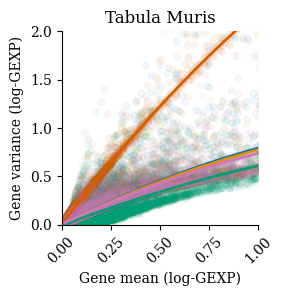

Wasserstein distance true/generated cellFlow: 0.03395039293581707
Energy distance true/generated cellFlow: 0.033546405516791174
Wasserstein distance true/generated scDiffusion: 0.6723094649667692
Energy distance true/generated scDiffusion: 0.8975053338509904
Wasserstein distance true/generated scGAN: 1.6422028728729585
Energy distance true/generated scGAN: 1.6356965453657866
Wasserstein distance true/generated scVI: 0.0705354689128988
Energy distance true/generated scVI: 0.08229474410910796
Removed 0 obs from Real data
Removed 0 obs from cellFlow
Removed 0 obs from scDiffusion
Removed 0 obs from scGAN
Removed 0 obs from scVI



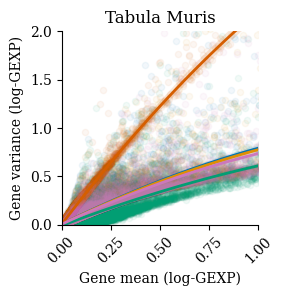

Wasserstein distance true/generated cellFlow: 0.03543737773527165
Energy distance true/generated cellFlow: 0.035540888706770885
Wasserstein distance true/generated scDiffusion: 0.6066594622917673
Energy distance true/generated scDiffusion: 0.8338717169781541
Wasserstein distance true/generated scGAN: 104.4821835246693
Energy distance true/generated scGAN: 10.503201162110871
Wasserstein distance true/generated scVI: 0.07083601412110169
Energy distance true/generated scVI: 0.08139961558684142
Removed 0 obs from Real data
Removed 0 obs from cellFlow
Removed 0 obs from scDiffusion
Removed 0 obs from scGAN
Removed 0 obs from scVI



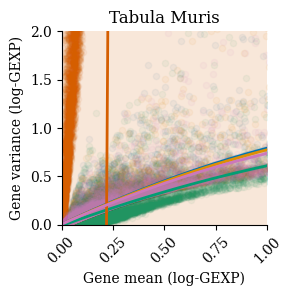

In [8]:
adata_real_tabula_muris = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/tabula_muris/tabula_muris_test.h5ad")
wasserstein_tab = {}
for i in range(3): 
    adata_celldreamer_tabula_muris = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/tabula_muris/generated_cells_{i}.h5ad")
    adata_scDiff_tabula_muris = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scDiffusion/generated/tabula_muris/generated_cells_{i}.h5ad")
    adata_scgan_tabula_muris = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scgan/model_runs/tabula_muris/tabula_muris_generated_{i}.h5ad")
    adata_scvi_tabula_muris = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scvi/tabula_muris/generated/tabula_muris_{i}.h5ad")
    wass = plot_log_mean_vs_log_variance(adata_real_tabula_muris, 
                              {"cellFlow": adata_celldreamer_tabula_muris,
                               "scDiffusion": adata_scDiff_tabula_muris, 
                              "scGAN": adata_scgan_tabula_muris, 
                              "scVI": adata_scvi_tabula_muris}, "Tabula Muris", 
                              folder=folder,
                              xlim=(0,1), ylim=(0,2), quantile=(0,1)
                             )
    wasserstein_tab = update_dict(wasserstein_tab, wass)

In [11]:
for w in wasserstein_tab:
    print(w)
    print(np.mean(wasserstein_tab[w]))
    print(np.std(wasserstein_tab[w])/np.sqrt(3))

cellFlow
0.03454412207665302
0.00037120466040941436
scDiffusion
0.6413392995275337
0.015547789849617593
scGAN
35.92141671835742
27.989815846998404
scVI
0.0704581575698915
0.00019886635070273277


## PBMC3K

Wasserstein distance true/generated cellFlow: 0.12758314794152814
Energy distance true/generated cellFlow: 0.2245489671936969
Wasserstein distance true/generated scDiffusion: 1.0228680319542682
Energy distance true/generated scDiffusion: 1.209515503372849
Wasserstein distance true/generated scGAN: 0.4390389002489127
Energy distance true/generated scGAN: 0.6320538956561916
Wasserstein distance true/generated scVI: 0.041853771528465325
Energy distance true/generated scVI: 0.07911603154418952
Removed 429 obs from Real data
Removed 429 obs from cellFlow
Removed 429 obs from scDiffusion
Removed 429 obs from scGAN
Removed 429 obs from scVI



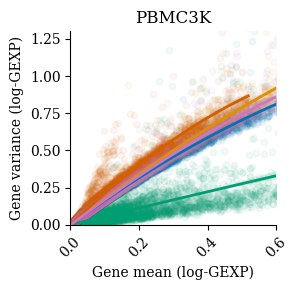

Wasserstein distance true/generated cellFlow: 0.15727260081356514
Energy distance true/generated cellFlow: 0.28692768055703965
Wasserstein distance true/generated scDiffusion: 1.0053883021657803
Energy distance true/generated scDiffusion: 1.1971665208851046
Wasserstein distance true/generated scGAN: 0.42385809064269553
Energy distance true/generated scGAN: 0.61129348499119
Wasserstein distance true/generated scVI: 0.0433636064443855
Energy distance true/generated scVI: 0.08174247146866319
Removed 429 obs from Real data
Removed 429 obs from cellFlow
Removed 429 obs from scDiffusion
Removed 429 obs from scGAN
Removed 429 obs from scVI



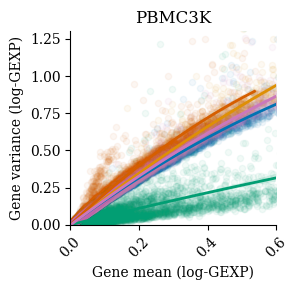

Wasserstein distance true/generated cellFlow: 0.123921737631373
Energy distance true/generated cellFlow: 0.2189313306282075
Wasserstein distance true/generated scDiffusion: 0.9865566067156216
Energy distance true/generated scDiffusion: 1.1822148569613387
Wasserstein distance true/generated scGAN: 0.4311568963568066
Energy distance true/generated scGAN: 0.6226023585793123
Wasserstein distance true/generated scVI: 0.02265573600784268
Energy distance true/generated scVI: 0.032683587803688505
Removed 429 obs from Real data
Removed 429 obs from cellFlow
Removed 429 obs from scDiffusion
Removed 429 obs from scGAN
Removed 429 obs from scVI



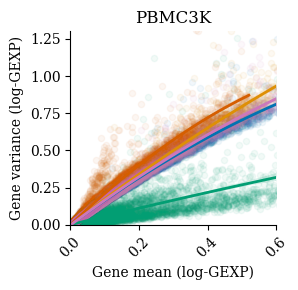

In [9]:
adata_real_pbmc3k = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/pbmc3k/pbmc3k_test.h5ad")
wasserstein_pbmc = {}

for i in range(3):
    adata_celldreamer_pbmc3k = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/pbmc3k/generated_cells_{i}.h5ad")
    adata_scDiff_pbmc3k = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scDiffusion/generated/pbmc3k/generated_cells_{i}.h5ad")
    adata_scgan_pbmc3k = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scgan/model_runs/pbmc3k/pbmc3k_generated_{i}.h5ad")
    adata_scvi_pbmc3k = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scvi/pbmc3k/generated/pbmc3k_{i}.h5ad")
    wass = plot_log_mean_vs_log_variance(adata_real_pbmc3k, 
                              {"cellFlow": adata_celldreamer_pbmc3k, "scDiffusion": adata_scDiff_pbmc3k,
                              "scGAN": adata_scgan_pbmc3k, "scVI": adata_scvi_pbmc3k}, "PBMC3K", 
                              folder=folder,
                              xlim=(0,0.60), ylim=(0,1.3), quantile=(0,0.95))
    wasserstein_pbmc = update_dict(wasserstein_pbmc, wass)

In [12]:
for w in wasserstein_pbmc:
    print(w)
    print(np.mean(wasserstein_pbmc[w]))
    print(np.std(wasserstein_pbmc[w])/np.sqrt(3))

cellFlow
0.13625916212882208
0.008621999450796645
scDiffusion
1.0049376469452234
0.008560662205841023
scGAN
0.4313512957494716
0.0035790311667934544
scVI
0.03595770466023117
0.005442153942250305


## HLCA CORE

Wasserstein distance true/generated cellFlow: 0.3961266285269091
Energy distance true/generated cellFlow: 0.631508907553102
Wasserstein distance true/generated scDiffusion: 1.2082556038342394
Energy distance true/generated scDiffusion: 1.3031464300362046
Wasserstein distance true/generated scGAN: 0.8081195812490749
Energy distance true/generated scGAN: 1.0489323747767834
Wasserstein distance true/generated scVI: 0.5212103223764221
Energy distance true/generated scVI: 0.7968754280479178
Removed 753 obs from Real data
Removed 753 obs from cellFlow
Removed 753 obs from scDiffusion
Removed 1398 obs from scGAN
Removed 753 obs from scVI



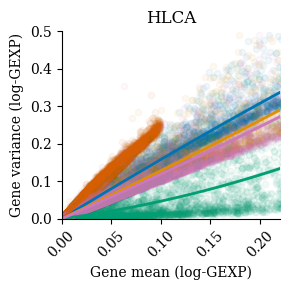

Wasserstein distance true/generated cellFlow: 0.3958608483085964
Energy distance true/generated cellFlow: 0.6309374996967351
Wasserstein distance true/generated scDiffusion: 1.267221264508202
Energy distance true/generated scDiffusion: 1.354457660473143
Wasserstein distance true/generated scGAN: 0.8097996054635686
Energy distance true/generated scGAN: 1.0512402435588741
Wasserstein distance true/generated scVI: 0.5215877270137272
Energy distance true/generated scVI: 0.7974896512780953
Removed 753 obs from Real data
Removed 753 obs from cellFlow
Removed 753 obs from scDiffusion
Removed 1398 obs from scGAN
Removed 753 obs from scVI



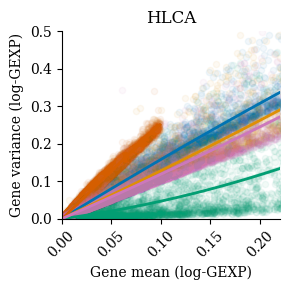

In [11]:
wasserstein_hlca = {}
for i in range(2):
    adata_real_hlca = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/hlca_core/hlca_core_test.h5ad")
    
    adata_celldreamer_hlca = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/hlca_core/generated_cells_{i}.h5ad")
    adata_scDiff_hlca = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scDiffusion/generated/hlca_core/generated_cells_{i}.h5ad")
    adata_scgan_hlca = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scgan/model_runs/hlca_core/hlca_core_generated_{i}.h5ad")
    adata_scvi_hlca = sc.read_h5ad(f"/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/scvi/hlca_core/generated/hlca_core_{i}.h5ad")
    
    adata_celldreamer_hlca.var = adata_real_hlca.var.copy()
    adata_scDiff_hlca.var = adata_real_hlca.var.copy()
    adata_scgan_hlca.var = adata_scgan_hlca.var.copy()
    adata_scvi_hlca.var = adata_real_hlca.var.copy()
    
    sc.pp.highly_variable_genes(adata_real_hlca, n_top_genes=15000, subset=True)
    
    adata_scDiff_hlca = adata_scDiff_hlca[:, adata_real_hlca.var.index]
    adata_celldreamer_hlca = adata_celldreamer_hlca[:, adata_real_hlca.var.index]
    adata_scgan_hlca = adata_scgan_hlca[:, adata_scgan_hlca.var.index]
    adata_scvi_hlca = adata_scvi_hlca[:, adata_real_hlca.var.index]
    
    wass = plot_log_mean_vs_log_variance(adata_real_hlca, 
                                  {"cellFlow": adata_celldreamer_hlca, "scDiffusion": adata_scDiff_hlca, 
                                  "scGAN": adata_scgan_hlca, "scVI": adata_scvi_hlca}, "HLCA", 
                                  folder=folder,
                                  xlim=(0,0.22), ylim=(0,0.50), quantile=(0,0.95))
    wasserstein_hlca = update_dict(wasserstein_hlca, wass)

In [12]:
for w in wasserstein_hlca:
    print(w)
    print(np.mean(wasserstein_hlca[w]))
    print(np.std(wasserstein_hlca[w])/np.sqrt(2))

cellFlow
0.39599373841775276
9.396749733707364e-05
scDiffusion
1.2377384341712205
0.020847509259851935
scGAN
0.8089595933563217
0.0005939782573130304
scVI
0.5213990246950746
0.00013343268914487065


In [13]:
wasserstein_hlca

{'cellFlow': [0.3961266285269091, 0.3958608483085964],
 'scDiffusion': [1.2082556038342394, 1.267221264508202],
 'scGAN': [0.8081195812490749, 0.8097996054635686],
 'scVI': [0.5212103223764221, 0.5215877270137272]}

# Replot only scVI and CFGen

In [ ]:
# from scipy.stats import wasserstein_distance
# from scipy.stats import energy_distance

In [ ]:
folder ="/home/icb/alessandro.palma/environment/cfgen/figs/overdispersion/scvi"

### Dentategyrus

In [ ]:
data_dent_small = plot_log_mean_vs_log_variance(adata_real_dent, 
                              {"scVI": adata_celldreamer_dent, 
                              "cellFlow": adata_scvi_dent}, 
                              "Dentate gyrus", 
                              folder=folder,
                              xlim=(1,2), ylim=(0.6,1.1), quantile=(0,0.99)
                             )

In [ ]:
# data_dent_small = pd.DataFrame(data_dent_small)
# data_dent_small_mean_var_trend = data_dent_small
# data_dent_small_mean_var_trend = data_dent_small_mean_var_trend.loc[:, ["Variance/Mean","Dataset"]]
# scvi_dent = data_dent_small_mean_var_trend.loc[data_dent_small_mean_var_trend.Dataset=="scVI", "Variance/Mean"].dropna()
# cfgen_dent = data_dent_small_mean_var_trend.loc[data_dent_small_mean_var_trend.Dataset=="cellFlow", "Variance/Mean"].dropna()
# real_dent = data_dent_small_mean_var_trend.loc[data_dent_small_mean_var_trend.Dataset=="Real data", "Variance/Mean"].dropna()

# print("Wasserstein distance scVI", wasserstein_distance(scvi_dent, real_dent))
# print("Energy distance scVI", energy_distance(scvi_dent, real_dent))
# print("Wasserstein distance CFGen", wasserstein_distance(cfgen_dent, real_dent))
# print("Energy CFGen", energy_distance(cfgen_dent, real_dent))

## Tabula Muris

In [ ]:
data_tabula_small = plot_log_mean_vs_log_variance(adata_real_tabula_muris, 
                              {"cellFlow": adata_celldreamer_tabula_muris,
                              "scVI": adata_scvi_tabula_muris}, "Tabula Muris", 
                              folder=folder,
                              xlim=(0.6,1), ylim=(0.5,0.9), quantile=(0,1)
                             )

In [24]:
# data_tabula_small = pd.DataFrame(data_tabula_small)
# data_tabula_small_mean_var_trend = data_tabula_small
# data_tabula_small_mean_var_trend = data_tabula_small_mean_var_trend.loc[:, ["Variance/Mean","Dataset"]]
# scvi_tabula = data_tabula_small_mean_var_trend.loc[data_tabula_small_mean_var_trend.Dataset=="scVI", "Variance/Mean"].dropna()
# cfgen_tabula = data_tabula_small_mean_var_trend.loc[data_tabula_small_mean_var_trend.Dataset=="cellFlow", "Variance/Mean"].dropna()
# real_tabula = data_tabula_small_mean_var_trend.loc[data_tabula_small_mean_var_trend.Dataset=="Real data", "Variance/Mean"].dropna()

# print("Wasserstein distance scVI", wasserstein_distance(scvi_tabula, real_tabula))
# print("Energy distance scVI", energy_distance(scvi_tabula, real_tabula))
# print("Wasserstein distance CFGen", wasserstein_distance(cfgen_tabula, real_tabula))
# print("Energy CFGen", energy_distance(cfgen_tabula, real_tabula))

## HLCA

Wasserstein distance true/generated cellFlow: 0.3961266285269091
Energy distance true/generated cellFlow: 0.631508907553102

Wasserstein distance true/generated scVI: 0.5212103223764221
Energy distance true/generated scVI: 0.7968754280479178

Removed 0 obs from Real data
Removed 0 obs from cellFlow
Removed 0 obs from scVI



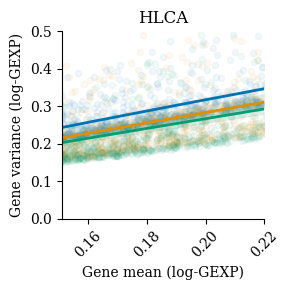

In [25]:
data_hlca_small = plot_log_mean_vs_log_variance(adata_real_hlca, 
                              {"cellFlow": adata_celldreamer_hlca, "scVI": adata_scvi_hlca}, "HLCA", 
                              folder=folder,
                              xlim=(0.1510,0.22), ylim=(0,0.50), quantile=(0,1))

In [26]:
# data_hlca_small = pd.DataFrame(data_hlca_small)
# data_hlca_small_mean_var_trend = data_hlca_small
# data_hlca_small_mean_var_trend = data_hlca_small_mean_var_trend.loc[:, ["Variance/Mean","Dataset"]]
# scvi_hlca = data_hlca_small_mean_var_trend.loc[data_hlca_small_mean_var_trend.Dataset=="scVI", "Variance/Mean"].dropna()
# cfgen_hlca = data_hlca_small_mean_var_trend.loc[data_hlca_small_mean_var_trend.Dataset=="cellFlow", "Variance/Mean"].dropna()
# real_hlca = data_hlca_small_mean_var_trend.loc[data_hlca_small_mean_var_trend.Dataset=="Real data", "Variance/Mean"].dropna()

# print("Wasserstein distance scVI", wasserstein_distance(scvi_hlca, real_hlca))
# print("Energy distance scVI", energy_distance(scvi_hlca, real_hlca))
# print("Wasserstein distance CFGen", wasserstein_distance(cfgen_hlca, real_hlca))
# print("Energy CFGen", energy_distance(cfgen_hlca, real_hlca))

## PBMC3k

Wasserstein distance true/generated CFGen: 0.12758314794152814
Energy distance true/generated CFGen: 0.2245489671936969

Wasserstein distance true/generated scVI: 0.041853771528465325
Energy distance true/generated scVI: 0.07911603154418952

Removed 0 obs from CFGen
Removed 0 obs from Real data
Removed 0 obs from scVI



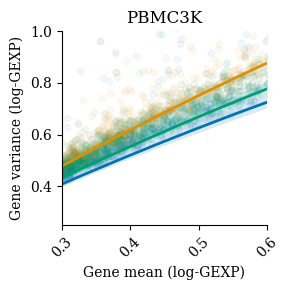

In [27]:
# PBMC3k

data_pbmc_small = plot_log_mean_vs_log_variance(adata_real_pbmc3k, 
                              {"CFGen": adata_celldreamer_pbmc3k, "scVI": adata_scvi_pbmc3k}, "PBMC3K", 
                              folder=folder,
                              xlim=(0.3,0.6), ylim=(0.25,1), quantile=(0,1)
                             )

In [28]:
# data_pbmc_small = pd.DataFrame(data_pbmc_small)
# data_pbmc_small_mean_var_trend = data_pbmc_small
# data_pbmc_small_mean_var_trend = data_pbmc_small_mean_var_trend.loc[:, ["Variance/Mean","Dataset"]]
# scvi_pbmc = data_pbmc_small_mean_var_trend.loc[data_pbmc_small_mean_var_trend.Dataset=="scVI", "Variance/Mean"].dropna()
# cfgen_pbmc = data_pbmc_small_mean_var_trend.loc[data_pbmc_small_mean_var_trend.Dataset=="cellFlow", "Variance/Mean"].dropna()
# real_pbmc = data_pbmc_small_mean_var_trend.loc[data_pbmc_small_mean_var_trend.Dataset=="Real data", "Variance/Mean"].dropna()

# print("Wasserstein distance scVI", wasserstein_distance(scvi_pbmc, real_pbmc))
# print("Energy distance scVI", energy_distance(scvi_pbmc, real_pbmc))
# print("Wasserstein distance CFGen", wasserstein_distance(cfgen_pbmc, real_pbmc))
# print("Energy CFGen", energy_distance(cfgen_pbmc, real_pbmc))